In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from network import ConvAutoEncoder
from models.pretrained.network import Network

In [2]:
# set available device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# extract and transform the data
train_set = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, num_workers=1)

In [4]:
pretrained_model = Network()
pretrained_model.load_state_dict(
    torch.load(f'models/pretrained/model-run(lr=0.001, batch_size=256).ckpt', map_location=device)
    )
# print(list(list(pretrained_model.features.children())[0].parameters()))
model = ConvAutoEncoder(pretrained_model)
# print(list(list(denoiser.children())[0].parameters()))
model

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (compressor): Sequential(
    (0): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1

In [5]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [6]:
model.to(device)
criterion = nn.MSELoss()
params = list(model.compressor.parameters()) + list(model.decoder.parameters()) 
optimizer = optim.Adam(params, lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=3, verbose=True)

In [7]:
num_epochs = 40
for epoch in range(num_epochs):
    train_loss = 0
    ###################
    # train the model #
    ###################
    loop = tqdm(train_loader, total=len(train_loader))
    for batch in loop:
        images, _ = batch[0].to(device), batch[1]
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=train_loss)

    scheduler.step(train_loss)

Epoch [40/40]: 100%|██████████| 235/235 [00:07<00:00, 33.47it/s, loss=227]


In [8]:
torch.save(model.state_dict(), 'models/model-autoencoder.pth')

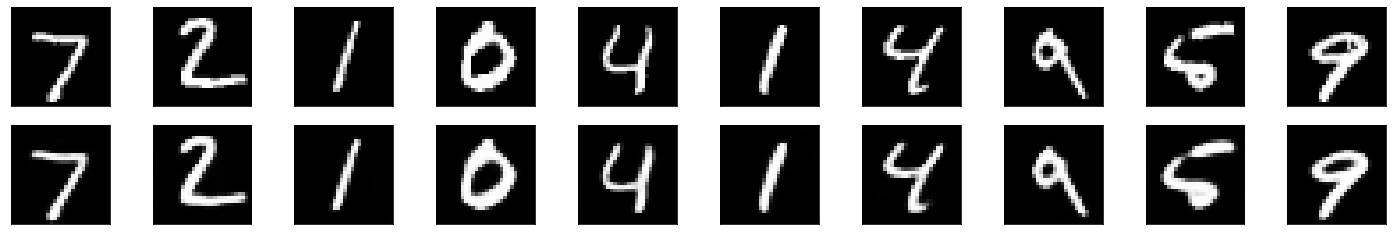

In [11]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.to(device)

# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)